<a href="https://colab.research.google.com/github/chirayu-khandelwal/Parkinson_Detection/blob/main/Parkinson_Detection_4_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
# from xgboost import XGBRegressor # Optional: Uncomment if XGBoost is installed and desired

# Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Other
from IPython.display import displayositories
32
Projects
Packages
Stars
133


In [2]:
# Install ucimlrepo if not already installed
try:
    import ucimlrepo
except ImportError:
    print("Installing ucimlrepo...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ucimlrepo"])
    import ucimlrepo

Installing ucimlrepo...


In [3]:
# Fetch the Parkinsons Telemonitoring dataset (ID 189)
from ucimlrepo import fetch_ucirepo

# fetch dataset
parkinsons_telemonitoring = fetch_ucirepo(id=189)

# data (as pandas dataframes)
X_data = parkinsons_telemonitoring.data.features
y_data = parkinsons_telemonitoring.data.targets

# --- Select Target Variable ---
# This dataset has two potential targets: 'motor_UPDRS' and 'total_UPDRS'.
# We will choose 'motor_UPDRS' for this example.
target_variable = 'motor_UPDRS'
y = y_data[[target_variable]] # Select the chosen target column
X = X_data

print(f"Using target variable: {target_variable}")

# metadata
print("\n--- Dataset Metadata ---")
print(parkinsons_telemonitoring.metadata)

# variable information
print("\n--- Variable Information ---")
print(parkinsons_telemonitoring.variables)

Using target variable: motor_UPDRS

--- Dataset Metadata ---
{'uci_id': 189, 'name': 'Parkinsons Telemonitoring', 'repository_url': 'https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring', 'data_url': 'https://archive.ics.uci.edu/static/public/189/data.csv', 'abstract': "Oxford Parkinson's Disease Telemonitoring Dataset", 'area': 'Health and Medicine', 'tasks': ['Regression'], 'characteristics': ['Tabular'], 'num_instances': 5875, 'num_features': 19, 'feature_types': ['Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['motor_UPDRS', 'total_UPDRS'], 'index_col': ['subject#'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5ZS3N', 'creators': ['Athanasios Tsanas', 'Max Little'], 'intro_paper': {'ID': 229, 'type': 'NATIVE', 'title': "Accurate Telemonitoring of Parkinson's Disease Progression by Noninvasive Speech Tests", 'authors': 'A. Tsanas, Max A. Littl

In [4]:
# Combine features and the selected target for exploration
df = pd.concat([X, y], axis=1)

# Exploring Dataset Content
print("\n--- Dataset Head ---")
display(df.head())

print('\n--- Initial Dataset Shape ---')
# Note: X.shape[1] is features only, df.shape[1] includes the target
print('Number of Features:', X.shape[1])
print('Number of Instances:', X.shape[0])
print('Shape including target:', df.shape)


--- Dataset Head ---


,age,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,sex,motor_UPDRS
0,72,5.6431,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006,0,28.199
1,72,12.6660,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810,0,28.447
2,72,19.6810,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014,0,28.695
3,72,25.6470,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277,0,28.905
4,72,33.6420,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361,0,29.187



--- Initial Dataset Shape ---
Number of Features: 19
Number of Instances: 5875
Shape including target: (5875, 20)


In [5]:
# Drop the subject identifier column
if 'subject#' in df.columns:
    print("\nDropping the 'subject#' column...")
    # Drop from both df (for exploration) and X (for modeling)
    df.drop(['subject#'], axis=1, inplace=True)
    X.drop(['subject#'], axis=1, inplace=True)
else:
    print("\n'subject#' column not found in the dataset.")

print('\n--- Dataset Shape After Dropping Identifier ---')
print('Number of Features:', X.shape[1])
print('Number of Instances:', X.shape[0])


'subject#' column not found in the dataset.

--- Dataset Shape After Dropping Identifier ---
Number of Features: 19
Number of Instances: 5875


In [6]:
# Exploring Information About Dataframe
print("\n--- Dataframe Info ---")
df.info()

print("\n--- Dataframe Description (Features and Target) ---")
display(df.describe())


--- Dataframe Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            5875 non-null   int64  
 1   test_time      5875 non-null   float64
 2   Jitter(%)      5875 non-null   float64
 3   Jitter(Abs)    5875 non-null   float64
 4   Jitter:RAP     5875 non-null   float64
 5   Jitter:PPQ5    5875 non-null   float64
 6   Jitter:DDP     5875 non-null   float64
 7   Shimmer        5875 non-null   float64
 8   Shimmer(dB)    5875 non-null   float64
 9   Shimmer:APQ3   5875 non-null   float64
 10  Shimmer:APQ5   5875 non-null   float64
 11  Shimmer:APQ11  5875 non-null   float64
 12  Shimmer:DDA    5875 non-null   float64
 13  NHR            5875 non-null   float64
 14  HNR            5875 non-null   float64
 15  RPDE           5875 non-null   float64
 16  DFA            5875 non-null   float64
 17  PPE            5875 non-null

,age,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,sex,motor_UPDRS
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,64.804936,92.863722,0.006154,0.000044,0.002987,0.003277,0.008962,0.034035,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589,0.317787,21.296229
std,8.821524,53.445602,0.005624,0.000036,0.003124,0.003732,0.009371,0.025835,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498,0.465656,8.129282
min,36.000000,-4.262500,0.000830,0.000002,0.000330,0.000430,0.000980,0.003060,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983,0.000000,5.037700
25%,58.000000,46.847500,0.003580,0.000022,0.001580,0.001820,0.004730,0.019120,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340,0.000000,15.000000
50%,65.000000,91.523000,0.004900,0.000034,0.002250,0.002490,0.006750,0.027510,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500,0.000000,20.871000
75%,72.000000,138.445000,0.006800,0.000053,0.003290,0.003460,0.009870,0.039750,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490,1.000000,27.596500
max,85.000000,215.490000,0.099990,0.000446,0.057540,0.069560,0.172630,0.268630,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730,1.000000,39.511000


In [7]:
# Checking For Duplicate Rows In Dataset
print('\n--- Duplicate Row Check ---')
print('Number of Duplicated Rows in df:', df.duplicated().sum())
# Note: Depending on the nature of telemonitoring data, duplicates might be expected or errors.
# Decide whether to drop duplicates based on domain knowledge.
# Example: df.drop_duplicates(inplace=True)
# If dropping duplicates in df, ensure X and y are aligned again or drop duplicates in X and y based on index.

# Checking For Missing Values In Dataset
print('\n--- Missing Value Check ---')
print(df.isna().sum())
# Note: If missing values are found, appropriate imputation strategies (mean, median, etc.) should be applied.


--- Duplicate Row Check ---
Number of Duplicated Rows in df: 0

--- Missing Value Check ---
age              0
test_time        0
Jitter(%)        0
Jitter(Abs)      0
Jitter:RAP       0
Jitter:PPQ5      0
Jitter:DDP       0
Shimmer          0
Shimmer(dB)      0
Shimmer:APQ3     0
Shimmer:APQ5     0
Shimmer:APQ11    0
Shimmer:DDA      0
NHR              0
HNR              0
RPDE             0
DFA              0
PPE              0
sex              0
motor_UPDRS      0
dtype: int64



--- Target Variable Distribution (motor_UPDRS) ---


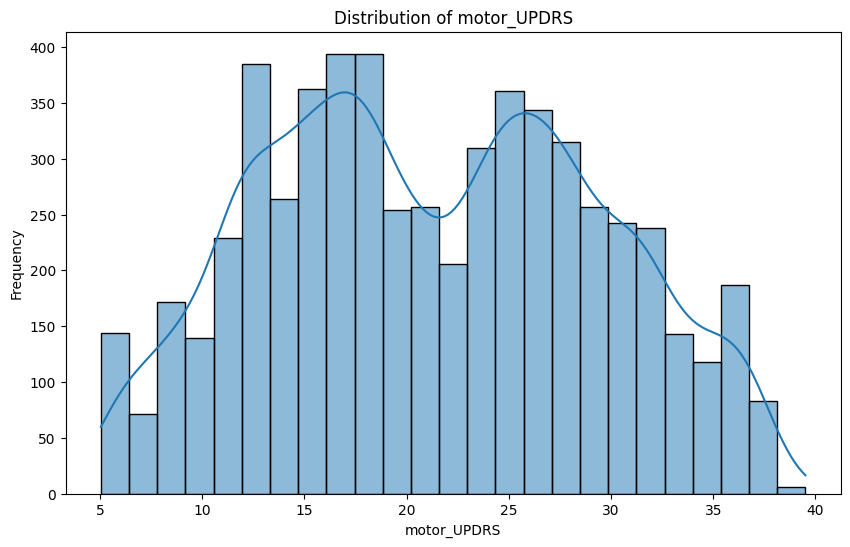

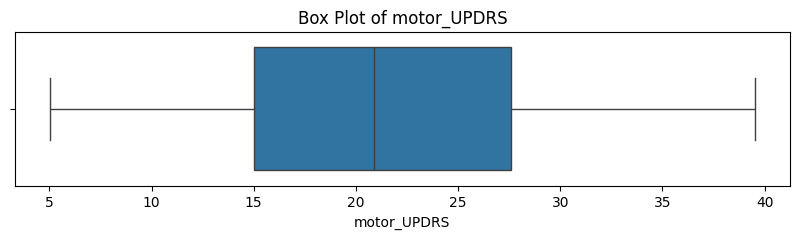

In [8]:
print(f"\n--- Target Variable Distribution ({target_variable}) ---")
plt.figure(figsize=(10, 6))
sns.histplot(df[target_variable], kde=True)
plt.title(f'Distribution of {target_variable}')
plt.xlabel(target_variable)
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 2))
sns.boxplot(x=df[target_variable])
plt.title(f'Box Plot of {target_variable}')
plt.show()


--- Correlation Heatmap (Features + Target) ---


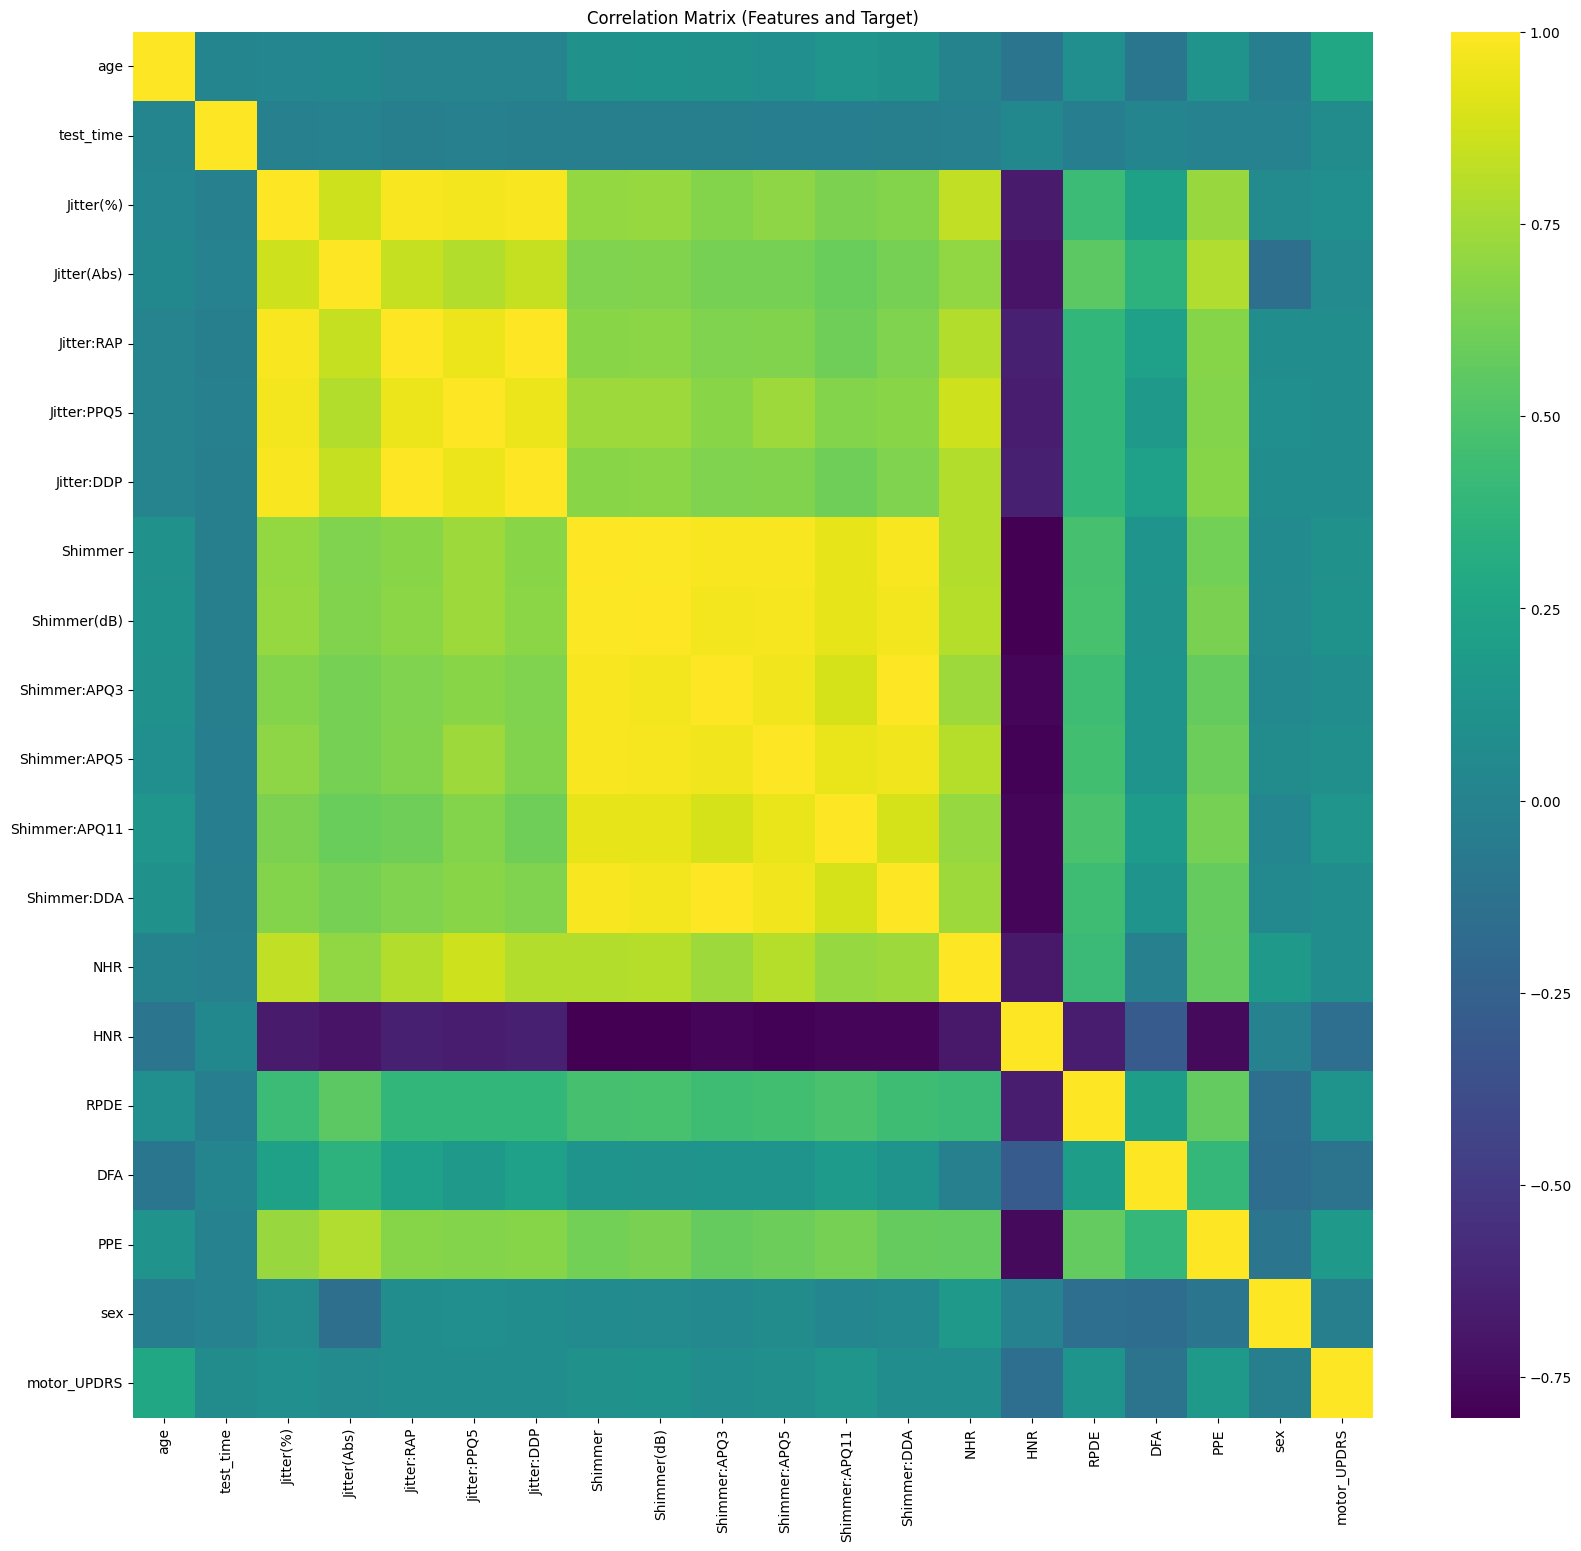


--- Top Correlations with motor_UPDRS ---


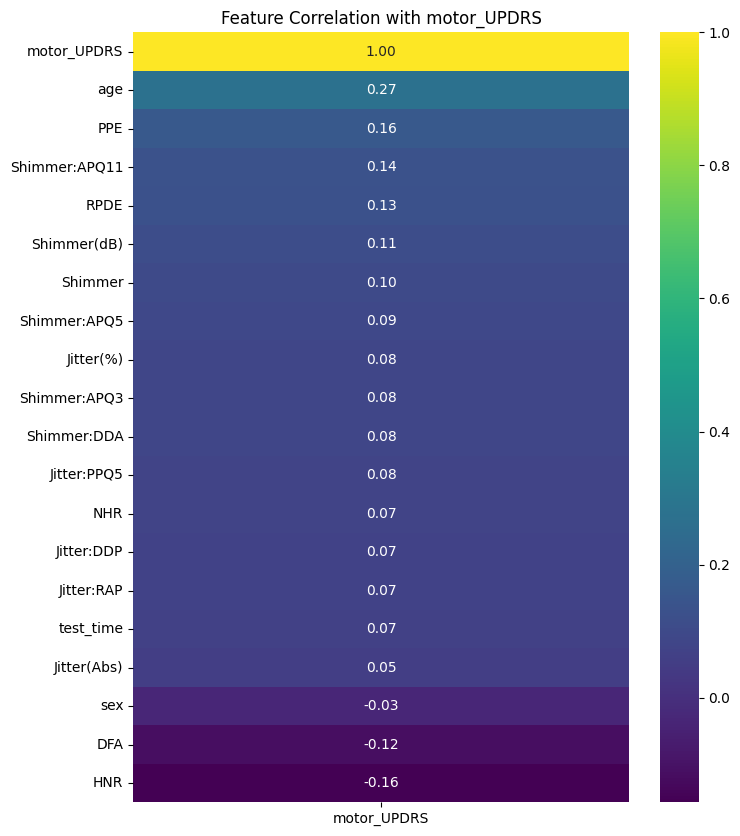

In [9]:
print("\n--- Correlation Heatmap (Features + Target) ---")
# Correlation heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(df.corr(), annot=False, cmap='viridis') # Annot=True is too crowded
plt.title('Correlation Matrix (Features and Target)')
plt.show()

print(f"\n--- Top Correlations with {target_variable} ---")
# Examine correlations with the target variable more closely
corr_matrix = df.corr()
target_corr = corr_matrix[[target_variable]].sort_values(by=target_variable, ascending=False)
plt.figure(figsize=(8, 10))
sns.heatmap(target_corr, annot=True, cmap='viridis', fmt=".2f")
plt.title(f'Feature Correlation with {target_variable}')
plt.show()


--- Box Plots for Feature Distributions ---


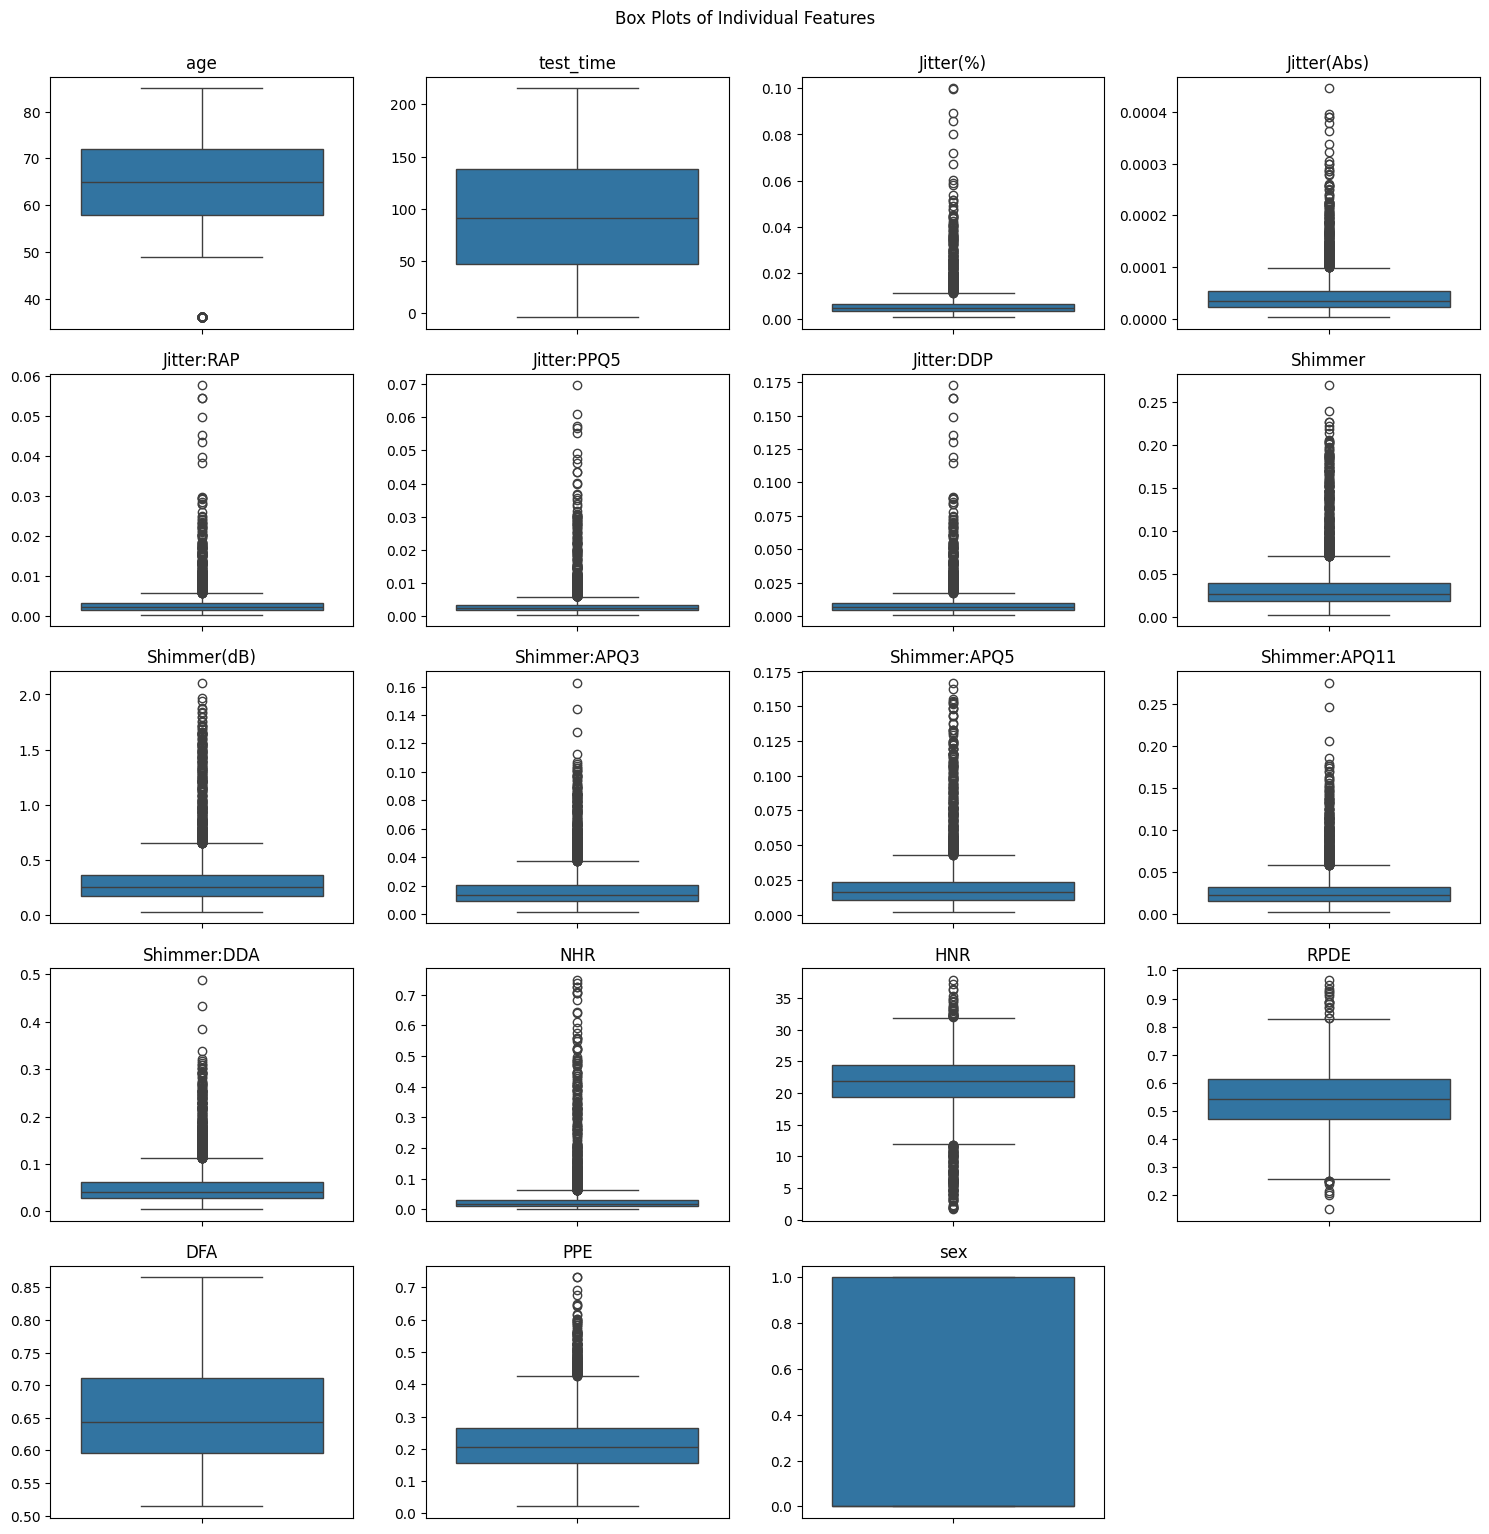

In [10]:
print("\n--- Box Plots for Feature Distributions ---")
# Box Plot of all features (excluding the target now)
feature_cols = X.columns # Use columns from X directly

num_features = len(feature_cols)
cols_plot = 4  # Number of columns in subplot grid
rows_plot = (num_features + cols_plot - 1) // cols_plot # Calculate rows needed

fig, axes = plt.subplots(rows_plot, cols_plot, figsize=(15, 3 * rows_plot))
axes = axes.flatten() # Flatten to 1D array for easy iteration

for i, col in enumerate(feature_cols):
    if i < len(axes): # Ensure we don't exceed the number of axes
        sns.boxplot(y=X[col], ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_ylabel('') # Remove y-label for cleaner look

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle('Box Plots of Individual Features', y=1.02)
plt.show()


--- Pair Plots for Selected Features --- 
(Might take a moment)


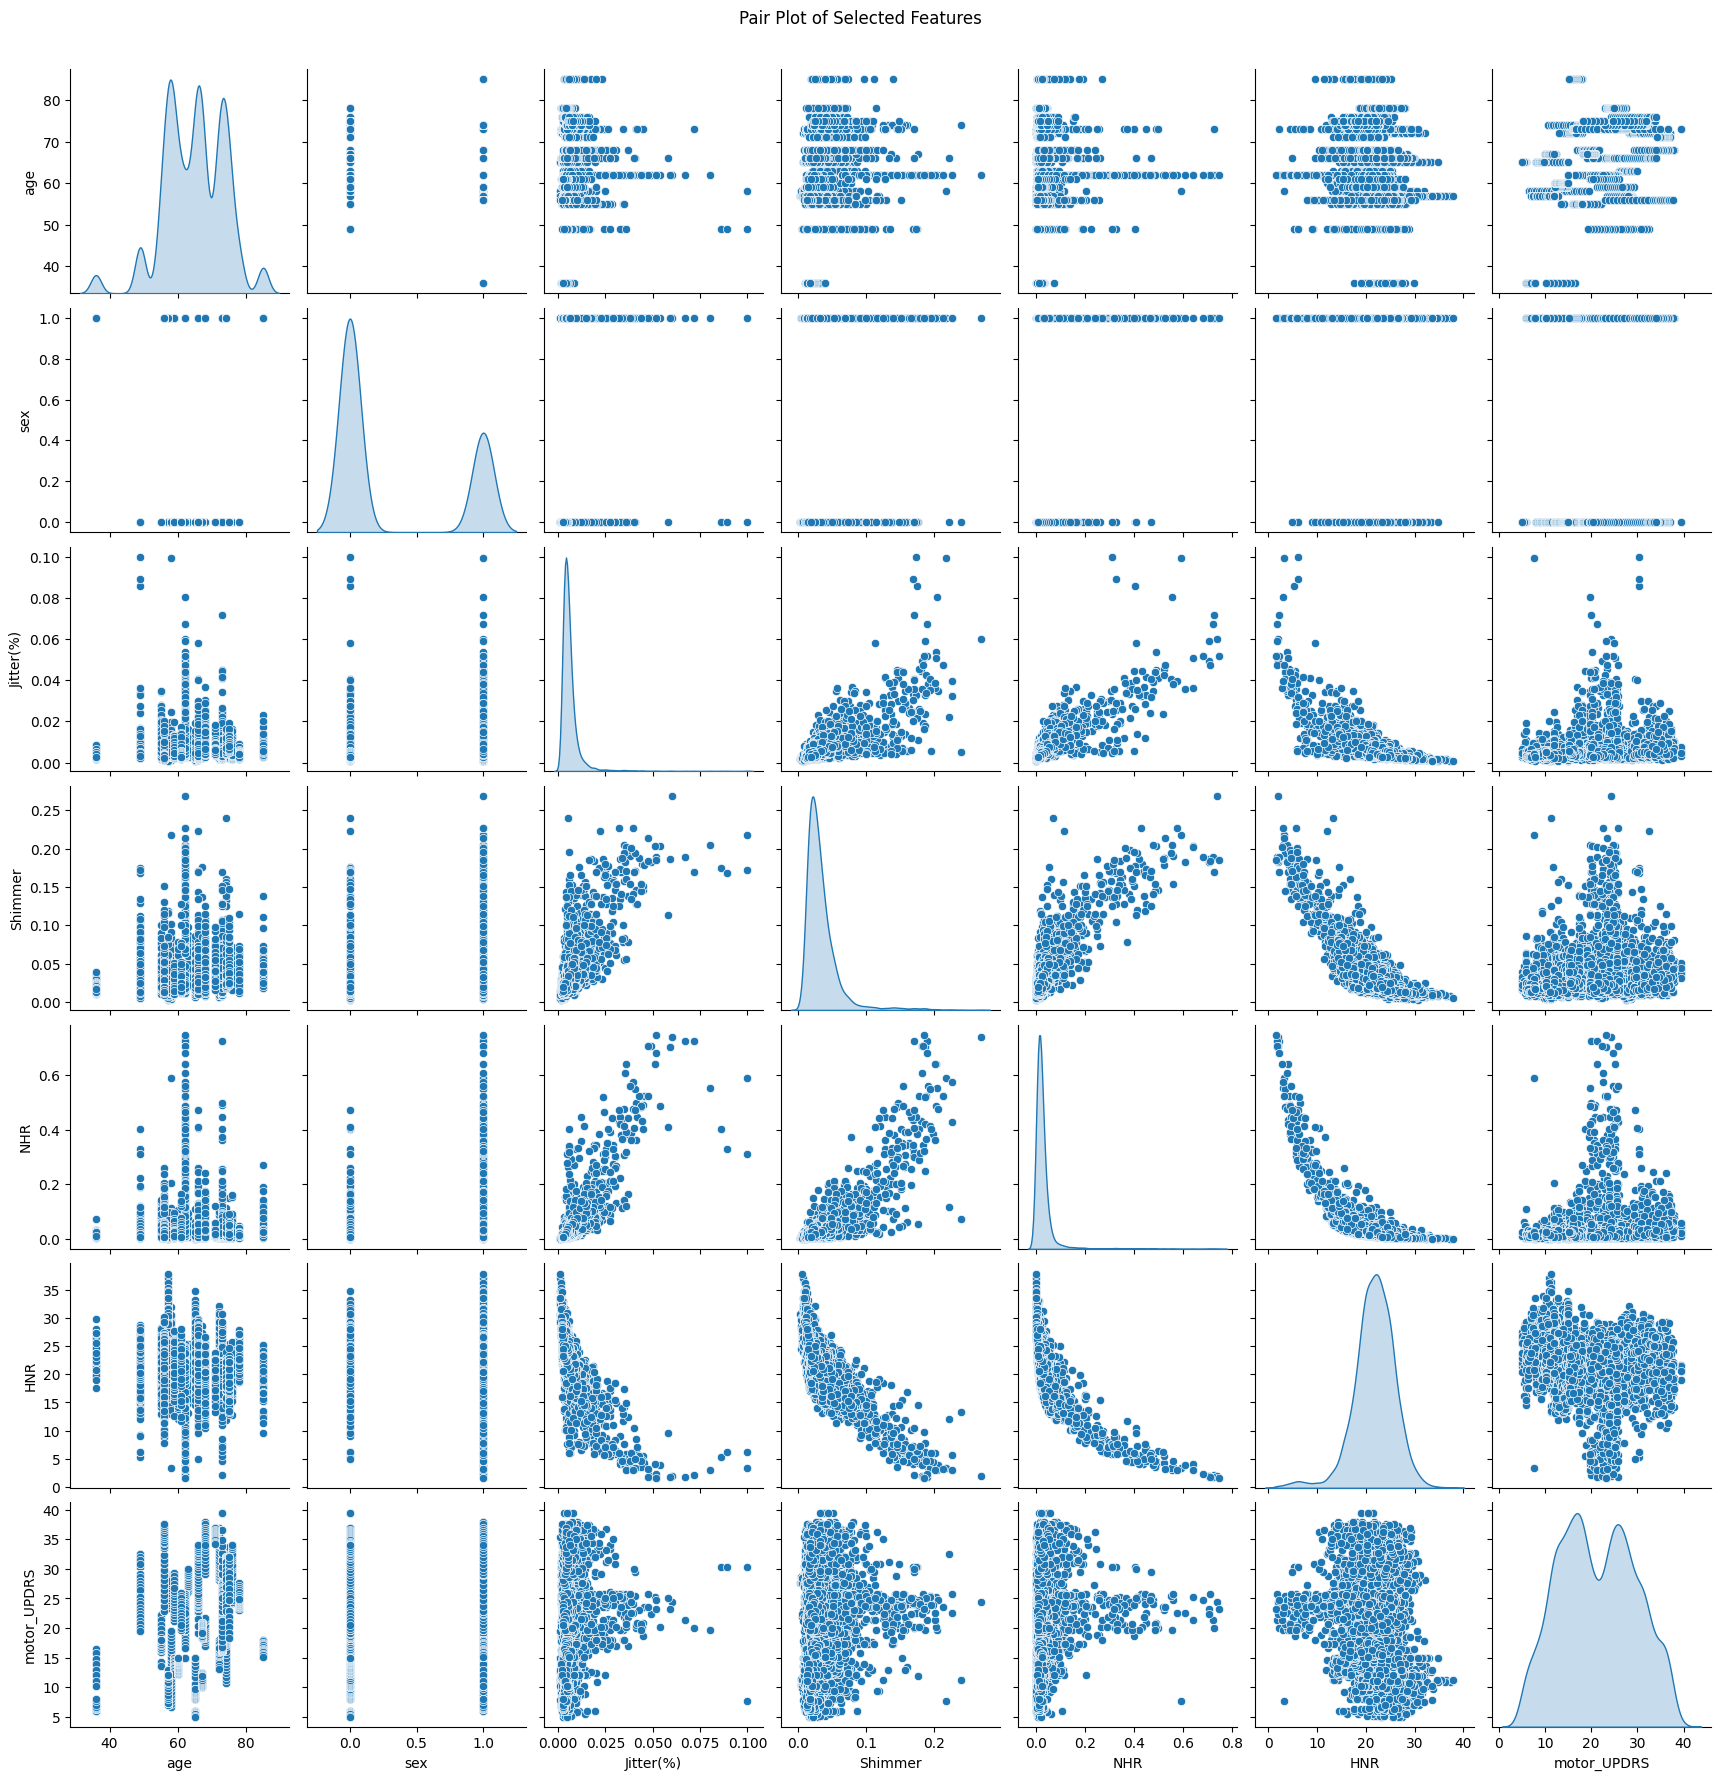

In [11]:
# Pair Plots (Optional - can be slow with many features)
# Select a subset of features if needed
cols_for_pairplot = ['age', 'sex', 'Jitter(%)', 'Shimmer', 'NHR', 'HNR', target_variable] # Example subset

# Check if columns exist before plotting
valid_cols_pairplot = [col for col in cols_for_pairplot if col in df.columns]

if len(valid_cols_pairplot) > 1:
    print("\n--- Pair Plots for Selected Features --- \n(Might take a moment)")
    # Add 'sex' as hue if desired, though it's numerical 0/1
    # sns.pairplot(df[valid_cols_pairplot], hue='sex', diag_kind='kde')
    sns.pairplot(df[valid_cols_pairplot], diag_kind='kde') # Without hue
    plt.suptitle('Pair Plot of Selected Features', y=1.02)
    plt.show()
else:
    print("\nSkipping pairplot - not enough valid columns selected or found.")

In [12]:
# --- Preprocessing for Modeling ---

# Scaling features between 0 and 1 (MinMaxScaler default range)
# Scaling is important for SVR, KNN, and often helps linear models.
print("\nScaling features using MinMaxScaler (0, 1)...")
scaler = MinMaxScaler()

# Fit on training data only, transform both train and test
# We need to split the data first.

# Convert y back to a 1D array for splitting and model fitting
y_1d = y[target_variable].values

# Splitting the dataset into training and testing sets (80% train, 20% test)
print("\nSplitting data into Training (80%) and Testing (20%) sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y_1d, test_size=0.20, random_state=42)

print("Training set shape (X, y):", X_train.shape, y_train.shape)
print("Testing set shape (X, y):", X_test.shape, y_test.shape)

# Now, fit the scaler on the training data and transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames for easier handling (optional, but keeps column names)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


Scaling features using MinMaxScaler (0, 1)...

Splitting data into Training (80%) and Testing (20%) sets...
Training set shape (X, y): (4700, 19) (4700,)
Testing set shape (X, y): (1175, 19) (1175,)


In [13]:
# --- Model Training and Evaluation Function ---

models = {}
results = {}

def train_evaluate_regressor(model, X_train, y_train, X_test, y_test, model_name):
    """Trains a regression model and prints evaluation metrics."""
    print(f"--- Training {model_name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n--- Evaluation Metrics for {model_name} ---")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")

    # Store results
    models[model_name] = model
    results[model_name] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

    # Scatter plot of Actual vs. Predicted
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--') # Diagonal line
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f'{model_name}: Actual vs. Predicted')
    plt.grid(True)
    plt.show()

    return model, y_pred

--- Training Linear Regression ---

--- Evaluation Metrics for Linear Regression ---
Mean Squared Error (MSE): 56.0139
Root Mean Squared Error (RMSE): 7.4842
Mean Absolute Error (MAE): 6.3534
R-squared (R²): 0.1224


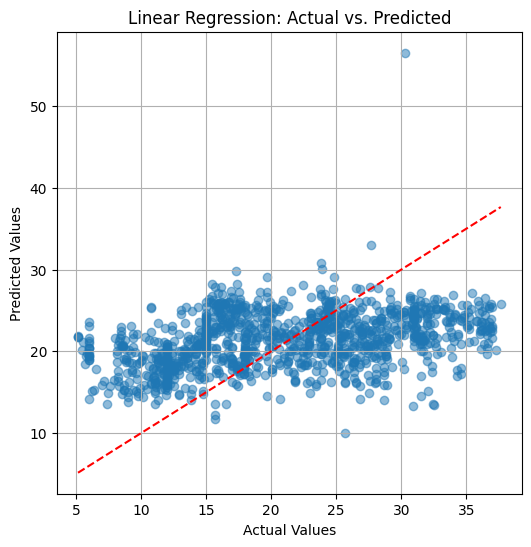

--- Training Ridge Regression ---

--- Evaluation Metrics for Ridge Regression ---
Mean Squared Error (MSE): 55.9960
Root Mean Squared Error (RMSE): 7.4830
Mean Absolute Error (MAE): 6.3650
R-squared (R²): 0.1227


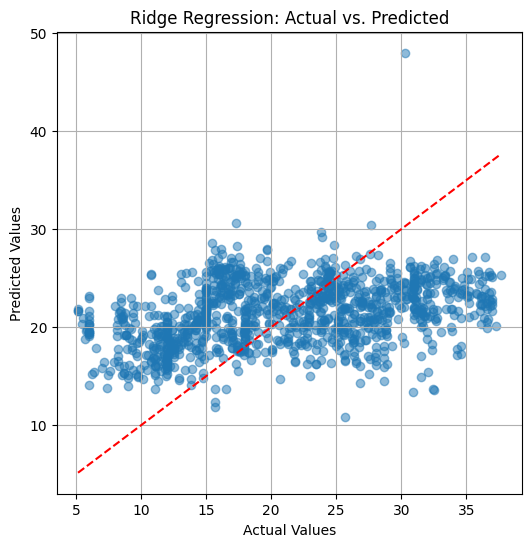

--- Training Lasso Regression ---

--- Evaluation Metrics for Lasso Regression ---
Mean Squared Error (MSE): 63.8624
Root Mean Squared Error (RMSE): 7.9914
Mean Absolute Error (MAE): 6.8778
R-squared (R²): -0.0005


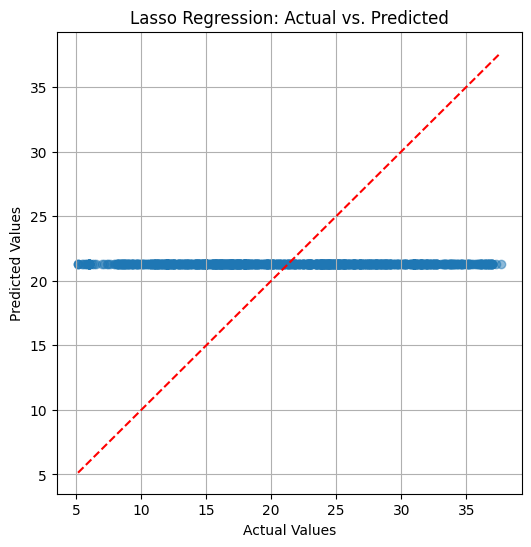

--- Training KNN Regressor (k=5) ---

--- Evaluation Metrics for KNN Regressor (k=5) ---
Mean Squared Error (MSE): 21.4524
Root Mean Squared Error (RMSE): 4.6317
Mean Absolute Error (MAE): 2.7063
R-squared (R²): 0.6639


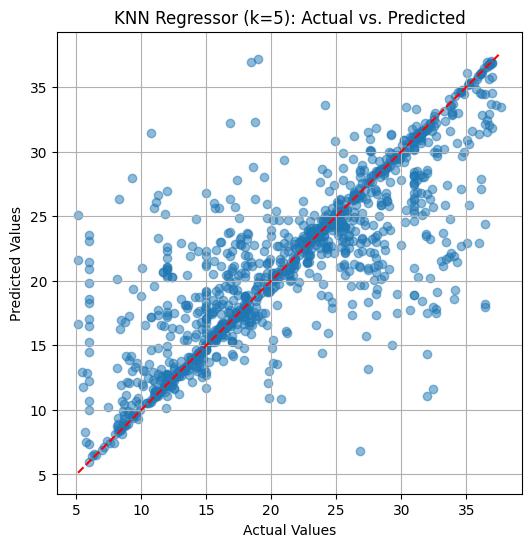

--- Training Decision Tree Regressor ---

--- Evaluation Metrics for Decision Tree Regressor ---
Mean Squared Error (MSE): 5.2641
Root Mean Squared Error (RMSE): 2.2944
Mean Absolute Error (MAE): 0.6087
R-squared (R²): 0.9175


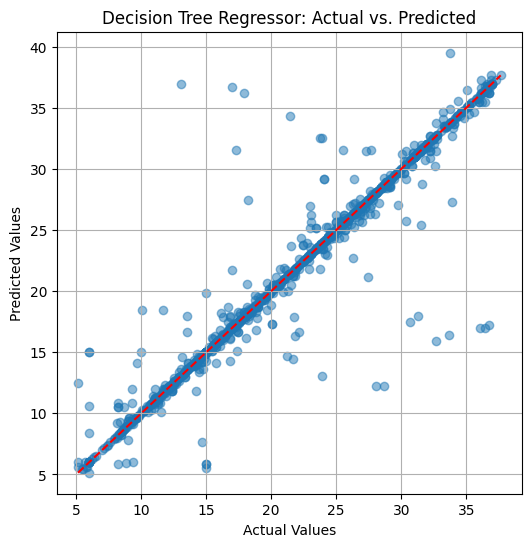

--- Training Random Forest Regressor ---

--- Evaluation Metrics for Random Forest Regressor ---
Mean Squared Error (MSE): 1.7617
Root Mean Squared Error (RMSE): 1.3273
Mean Absolute Error (MAE): 0.6190
R-squared (R²): 0.9724


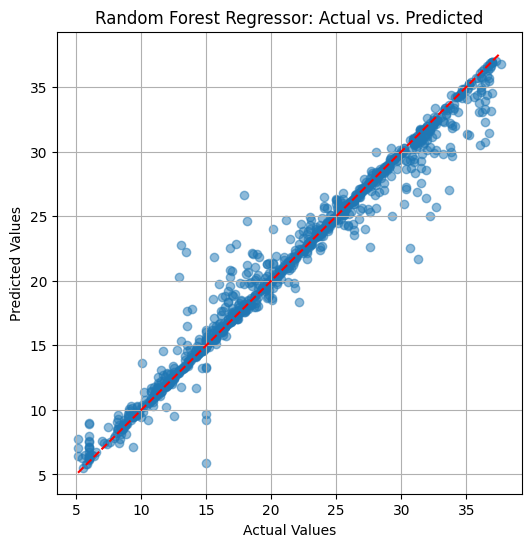

--- Training SVR (RBF Kernel) ---

--- Evaluation Metrics for SVR (RBF Kernel) ---
Mean Squared Error (MSE): 49.7147
Root Mean Squared Error (RMSE): 7.0509
Mean Absolute Error (MAE): 5.5541
R-squared (R²): 0.2211


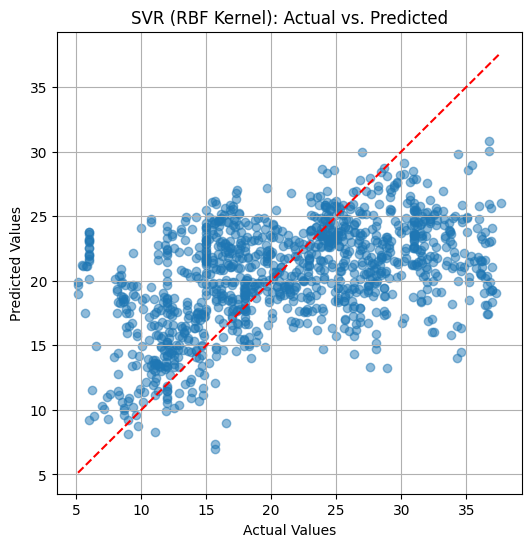

In [14]:
# --- Train and Evaluate Base Models ---
# Using scaled data for models sensitive to feature scaling

# 1. Linear Regression
lr = LinearRegression()
_, _ = train_evaluate_regressor(lr, X_train_scaled, y_train, X_test_scaled, y_test, "Linear Regression")

# 2. Ridge Regression
ridge = Ridge(random_state=42)
_, _ = train_evaluate_regressor(ridge, X_train_scaled, y_train, X_test_scaled, y_test, "Ridge Regression")

# 3. Lasso Regression
lasso = Lasso(random_state=42)
_, _ = train_evaluate_regressor(lasso, X_train_scaled, y_train, X_test_scaled, y_test, "Lasso Regression")

# 4. K-Nearest Neighbors Regressor
knn = KNeighborsRegressor() # Default n_neighbors=5
_, _ = train_evaluate_regressor(knn, X_train_scaled, y_train, X_test_scaled, y_test, "KNN Regressor (k=5)")

# 5. Decision Tree Regressor
# Tree-based models are less sensitive to scaling, but using scaled data is fine.
dtr = DecisionTreeRegressor(random_state=42)
_, _ = train_evaluate_regressor(dtr, X_train_scaled, y_train, X_test_scaled, y_test, "Decision Tree Regressor")

# 6. Random Forest Regressor
rfr = RandomForestRegressor(random_state=42, n_estimators=100) # n_estimators is an important parameter
_, _ = train_evaluate_regressor(rfr, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest Regressor")

# 7. Support Vector Regressor (SVR)
svr = SVR() # Default kernel is 'rbf'
_, _ = train_evaluate_regressor(svr, X_train_scaled, y_train, X_test_scaled, y_test, "SVR (RBF Kernel)")


--- Hyperparameter Tuning for RandomForestRegressor ---
Running GridSearchCV for RandomForestRegressor... (Might take time)
Fitting 3 folds for each of 72 candidates, totalling 216 fits

Best Parameters found for RandomForestRegressor:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
--- Training Random Forest Regressor (Tuned) ---

--- Evaluation Metrics for Random Forest Regressor (Tuned) ---
Mean Squared Error (MSE): 14.3294
Root Mean Squared Error (RMSE): 3.7854
Mean Absolute Error (MAE): 2.9658
R-squared (R²): 0.7755


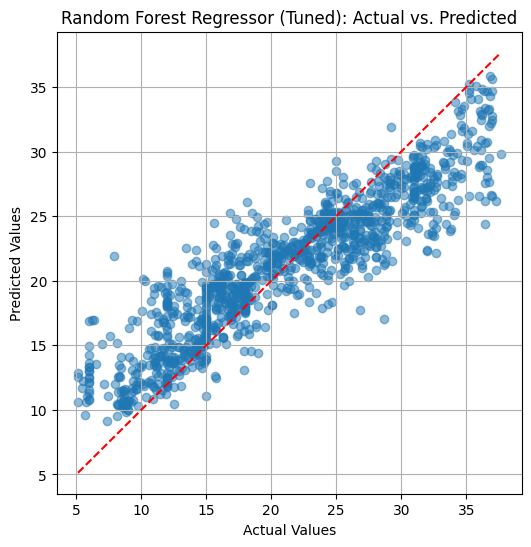

In [15]:
# --- Hyperparameter Tuning (Example: RandomForestRegressor) ---

print("\n--- Hyperparameter Tuning for RandomForestRegressor ---")

# Define a smaller parameter grid for faster tuning example
param_grid_rfr = {
    'n_estimators': [50, 100, 200],      # Number of trees
    'max_depth': [None, 10, 20],         # Maximum depth of trees
    'min_samples_split': [2, 5],         # Minimum samples to split a node
    'min_samples_leaf': [1, 3],          # Minimum samples in a leaf node
    'max_features': ['sqrt', 'log2'] # Number of features to consider for best split ('auto' is all features)
}

# Initialize GridSearchCV
# Scoring: 'neg_mean_squared_error' (higher is better, so GridSearchCV minimizes MSE)
# Or use 'r2' (higher is better)
grid_search_rfr = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                               param_grid=param_grid_rfr,
                               cv=3, # Use 3-fold CV for speed
                               n_jobs=-1, # Use all available cores
                               scoring='neg_mean_squared_error',
                               verbose=1)

# Fit GridSearchCV
print("Running GridSearchCV for RandomForestRegressor... (Might take time)")
grid_search_rfr.fit(X_train_scaled, y_train)

print("\nBest Parameters found for RandomForestRegressor:")
print(grid_search_rfr.best_params_)

best_rfr = grid_search_rfr.best_estimator_

# Evaluate the tuned model
_, _ = train_evaluate_regressor(best_rfr, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest Regressor (Tuned)")


--- Hyperparameter Tuning for SVR ---
Running GridSearchCV for SVR... (Might take time)
Fitting 3 folds for each of 32 candidates, totalling 96 fits

Best Parameters found for SVR:
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}
--- Training SVR (Tuned) ---

--- Evaluation Metrics for SVR (Tuned) ---
Mean Squared Error (MSE): 30.5125
Root Mean Squared Error (RMSE): 5.5238
Mean Absolute Error (MAE): 4.0884
R-squared (R²): 0.5220


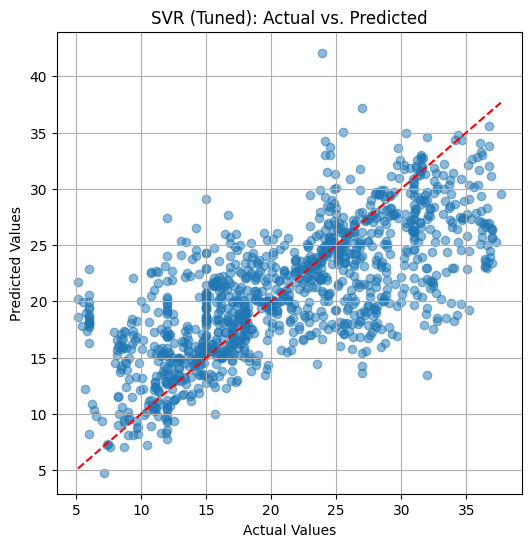

In [16]:
# --- Hyperparameter Tuning (Example: SVR) ---

print("\n--- Hyperparameter Tuning for SVR ---")

# Define parameter grid for SVR
param_grid_svr = {
    'C': [0.1, 1, 10, 100],            # Regularization parameter
    'gamma': ['scale', 'auto', 0.1, 1], # Kernel coefficient for 'rbf'
    'kernel': ['rbf', 'linear']         # Kernel type
    # 'epsilon': [0.1, 0.2]             # Epsilon in the epsilon-SVR model (optional to tune)
}

# Initialize GridSearchCV
grid_search_svr = GridSearchCV(estimator=SVR(),
                             param_grid=param_grid_svr,
                             cv=3,
                             n_jobs=-1,
                             scoring='neg_mean_squared_error',
                             verbose=1)

# Fit GridSearchCV
print("Running GridSearchCV for SVR... (Might take time)")
grid_search_svr.fit(X_train_scaled, y_train)

print("\nBest Parameters found for SVR:")
print(grid_search_svr.best_params_)

best_svr = grid_search_svr.best_estimator_

# Evaluate the tuned model
_, _ = train_evaluate_regressor(best_svr, X_train_scaled, y_train, X_test_scaled, y_test, "SVR (Tuned)")

In [17]:
# # --- Model Comparison ---

# print("\n--- Performance Metrics Summary ---")

# # Create DataFrame from the results dictionary
# results_df = pd.DataFrame(results).T # Transpose to have models as rows
# results_df = results_df.sort_values(by='RMSE', ascending=True) # Sort by RMSE (lower is better)

# display(results_df.round(4))

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


# --- Model Comparison Chart ---

print("\n--- Performance Metrics Summary --- (Lower is better for MAE/MSE/RMSE, Higher is better for R2) ---")

# Check if the 'results' dictionary exists from previous cells
if 'results' not in globals():
    print("Error: 'results' dictionary not found. Please run the model training cells first.")
else:
    # Define the order of metrics for the chart
    metric_order = ['R2-Score', 'MAE(Mean absolute error)', 'MSE(Mean squared error)', 'RMSE (Root Mean Square Error)']  # R2 first (higher is better), then error metrics (lower is better)

    # Prepare data for the DataFrame in the requested format style
    chart_data = {'Metric': metric_order}

    # Iterate through the models and their results
    for model_name, metrics_dict in results.items():
        # Extract metrics in the desired order
        metric_values = [metrics_dict.get(metric, None) for metric in metric_order]
        chart_data[model_name] = metric_values

    # Create DataFrame
    chart_df = pd.DataFrame(chart_data)

    # Set 'Metric' as index for better readability (optional)
    # chart_df.set_index('Metric', inplace=True)

    # Display the chart
    display(chart_df.round(4))  # Round for better display

    # # Optional: Display the transposed version as well (Models as rows)
    # print("\n--- Performance Metrics Summary (Transposed) ---")
    # display(pd.DataFrame(results).T.round(4).sort_values(by='RMSE'))


--- Performance Metrics Summary --- (Lower is better for MAE/MSE/RMSE, Higher is better for R2) ---


,Metric,Linear Regression,Ridge Regression,Lasso Regression,KNN Regressor (k=5),Decision Tree Regressor,Random Forest Regressor,SVR (RBF Kernel),Random Forest Regressor (Tuned),SVR (Tuned)
0,R2-Score,None,None,None,None,None,None,None,None,None
1,MAE(Mean absolute error),None,None,None,None,None,None,None,None,None
2,MSE(Mean squared error),None,None,None,None,None,None,None,None,None
3,RMSE (Root Mean Square Error),None,None,None,None,None,None,None,None,None



--- Feature Importances (Random Forest Regressor (Tuned)) ---


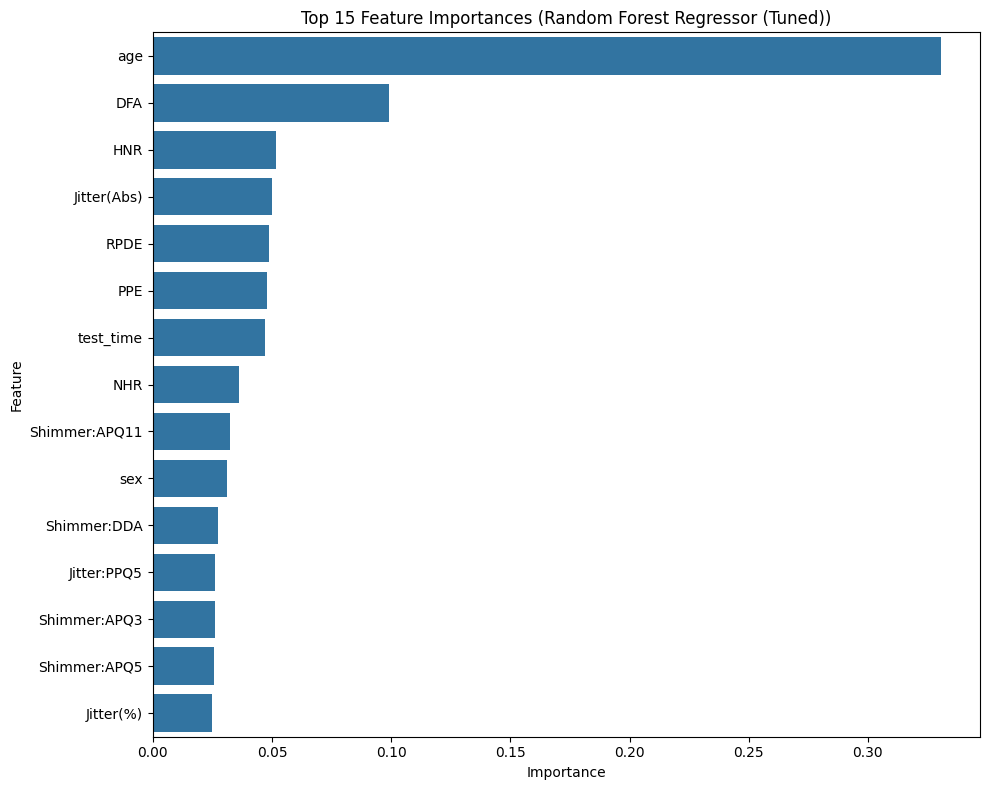

,Feature,Importance
0,age,0.330499
16,DFA,0.099157
14,HNR,0.051759
3,Jitter(Abs),0.049840
15,RPDE,0.048568
17,PPE,0.047893
1,test_time,0.047070
13,NHR,0.036099
11,Shimmer:APQ11,0.032347
18,sex,0.031273


In [18]:
# --- Feature Importance (from Tree-based models) ---

# Use the tuned Random Forest model if available, otherwise the base one
if 'Random Forest Regressor (Tuned)' in models:
    rfr_model_for_importance = models['Random Forest Regressor (Tuned)']
    model_name_imp = 'Random Forest Regressor (Tuned)'
elif 'Random Forest Regressor' in models:
    rfr_model_for_importance = models['Random Forest Regressor']
    model_name_imp = 'Random Forest Regressor'
else:
    rfr_model_for_importance = None
    model_name_imp = None

if rfr_model_for_importance:
    print(f"\n--- Feature Importances ({model_name_imp}) ---")
    importances = rfr_model_for_importance.feature_importances_
    feature_names = X_train.columns # Get feature names from original X_train

    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(15)) # Plot top 15 features
    plt.title(f'Top 15 Feature Importances ({model_name_imp})')
    plt.tight_layout()
    plt.show()

    display(importance_df.head(15))
else:
    print("\nCould not find a trained Random Forest model for feature importance.")

In [19]:
print("\n--- End of Analysis ---")


--- End of Analysis ---
